In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
import jReversion as jR
from LDOI import BooleanDOI_processing as BDOIp
from LDOI import qm
import pandas as pd
import numpy as np
import networkx as nx
import random
from functools import reduce

In [ ]:
# def randomize_regulator(g_read, mapping, input_nodes, output_nodes, p=0.2):
#     g_copy = g_read.copy()
#     input_nodes_idx = set([int(mapping[x].replace('n', '').replace('~','')) for x in input_nodes])
#     output_nodes_idx = set([int(mapping[x].replace('n', '').replace('~', '')) for x in output_nodes])
#     internal_nodes_idx = set(range(len(g_copy))).difference(input_nodes_idx.union(output_nodes_idx))

#     for ni in internal_nodes_idx.union(output_nodes_idx):
#         if np.random.rand() < p:
#             num_regulator = len(g_copy.nodes[ni]['update_nodes'])
#             temp = internal_nodes_idx.copy()
#             temp = temp.union(input_nodes_idx)
#             temp.discard(ni)
#             new_regulator = random.sample(temp, num_regulator)
#             g_copy.nodes[ni]['update_nodes'] = new_regulator
#             g_copy.remove_edges_from(list(g_copy.in_edges(ni)))
#             g_copy.add_edges_from(zip(new_regulator, np.tile([ni], num_regulator)))

#     return g_copy


# def randomize_target(g_read, mapping, input_nodes, output_nodes, p=0.2):
#     g_copy = g_read.copy()
#     input_nodes_idx = set([int(mapping[x].replace('n', '').replace('~','')) for x in input_nodes])
#     output_nodes_idx = set([int(mapping[x].replace('n', '').replace('~', '')) for x in output_nodes])
#     internal_nodes_idx = set(range(len(g_copy))).difference(input_nodes_idx.union(output_nodes_idx))

#     for ni in internal_nodes_idx.union(output_nodes_idx):
#         if np.random.rand() < p:
#             num_regulator = len(g_copy.nodes[ni]['update_nodes'])
#             temp = internal_nodes_idx.copy()
#             temp = temp.union(input_nodes_idx)
#             temp.discard(ni)
#             new_regulator = random.sample(temp, num_regulator)
#             # g_copy.nodes[ni]['update_nodes'] = new_regulator
#             g_copy.remove_edges_from(list(g_copy.out_edges(ni)))
#             g_copy.add_edges_from(zip(np.tile([ni], num_regulator), new_regulator))

#     return g_copy

In [25]:
def randomize_logic(g_read, mapping, input_nodes, output_nodes, n=1, bias=0.5):
    g_copy = g_read.copy()
    input_nodes_idx = set([int(mapping[x].replace('n', '').replace('~','')) for x in input_nodes])
    output_nodes_idx = set([int(mapping[x].replace('n', '').replace('~', '')) for x in output_nodes])
    internal_nodes_idx = set(range(len(g_copy))).difference(input_nodes_idx.union(output_nodes_idx))
    
    perturbed_node_idx = random.sample(internal_nodes_idx, n)
    
    def clean_states(x):
        #cleans binary representation of node input states
        out=x[2:]                                                               # Strip leading 0b
        return '0'*(len(inf)-len(out))+out                                      # Append leading 0's as needed
    
    for idx in perturbed_node_idx:
        inf = list(g_copy.predecessors(idx))
        if len(inf) > 0: 
            
            g_copy.nodes[idx]['update_rules'] = {}

            bool_states = map(bin,range(2**len(inf)))
            bool_states = map(clean_states,bool_states)
            canalizing_variable = random.randrange(len(inf))
            canalizing_value = int(random.random() < 0.5)
            canalized_value = int(random.random() < 0.5)
            for j in bool_states: # Store outcome for every possible input
                if j[canalizing_variable] == str(canalizing_value):
                    g_copy.nodes[idx]['update_rules'][j] = canalized_value
                else: 
                    g_copy.nodes[idx]['update_rules'][j] = int(random.random() < bias)    
        else:
#             g.add_edge(n, n)
            
            g_copy.nodes[idx]['update_rules'] = {'0': 0, '1': 1}
        
        
    return g_copy, perturbed_node_idx

In [26]:
def robustness_of_node_classfication(model, perturbation_n):

    Prefix, Suffix = 'n', 'n'
    TEMP = jR.cellcollective(model, Prefix, Suffix, directory='../')

    BooleanRuleFileName = TEMP['BooleanRule_filename']
    NetworkName = TEMP['network_name']

    NumInputs = TEMP['num_inputs']
    NumInputConditions = TEMP['num_input_conditions']

    InputConditions = TEMP['input_conditions']

    OutputNodes = TEMP['output_nodes']
    InputNodes = TEMP['input_nodes']

    # print(model + '- Nodes: ' + str(len(TEMP['Gread'])) + ' Input:' + str(len(InputNodes)) + ' Output:' + str(len(OutputNodes)))

    Mapping = TEMP['mapping']
    InverseMapping = TEMP['inverse_mapping']
    GRead = TEMP['Gread']
    ReadNodes = TEMP['read_nodes']

    GPerturb, perturbed_node_idx = randomize_logic(GRead, Mapping, InputNodes, OutputNodes, perturbation_n)

    GExpanded = BDOIp.Get_expanded_network(GPerturb, prefix=Prefix, suffix=Suffix)

    # integrated_data = pd.read_csv('../data/' + network_name + '_table_for_original_network.tsv', sep='\t').sort_values(by='node').set_index('node')
    # table_original_network = table_original_network.sort_values(by='node')
    # ffl_test = pd.read_csv('../data/' + network_name + '_ffl_test.tsv', sep='\t').sort_values(by='node').set_index('node')
    # canalizing_test = pd.read_csv('../data/' + network_name + '_canalizing_check_for_original_network.tsv', sep='\t').sort_values(by='node').set_index('node')

    TempGIOW = jR.get_input_output_relation(GExpanded, Mapping, InverseMapping, InputConditions, OutputNodes,
                                                constant_nodes=[])
    LDOIs = TempGIOW['LDOIs']
    GeneLDOIs = TempGIOW['gene_LDOIs']
    Conflicts = TempGIOW['conflicts']
    GeneConflicts = TempGIOW['gene_conflicts']
    IORelation = TempGIOW['io_relation']
    GRemained = TempGIOW['G_remained']

    R0 = jR.identifying_r0_mutations_ldoi(GExpanded, OutputNodes, Mapping, InverseMapping, InputConditions, IORelation)
    # DM = jR.identifying_disconnecting_mutations(GExpanded, InputNodes, OutputNodes, Mapping, InverseMapping)
    R1 = jR.identifying_r1_mutations_ldoi(GExpanded, OutputNodes, Mapping, InverseMapping, InputConditions, IORelation)
    #     IIDC = jR.identifying_input_independent_canalizing_mutations(GExpanded, OutputNodes, Mapping, InverseMapping)
    #     UN = jR.identifying_input_unreachable_nodes(GExpanded, OutputNodes, Mapping, InverseMapping, InputConditions)
    RN = jR.identifying_rn_mutations(GExpanded, Mapping, InverseMapping, InputNodes, OutputNodes, InputConditions,
                                     IORelation,
                                     R0['ineffective_mutations'], R1['r1_mutations'])

    NodeList = set(ReadNodes.values())
    NodeList.difference_update(InputNodes)
    NodeList.difference_update(OutputNodes)
    C0, C1, C2, C3 = [], [], [], []

    node_classificatin_dict = {}

    for NODE in NodeList:
        negNODE = '~' + NODE
        if R0['ineffective'][NODE] and R0['ineffective'][negNODE]:
    #             nodeClass = 'C0'
            node_classificatin_dict[NODE] = 'C0'
        elif NODE in RN['rn_mutations']:
            if RN['rn_mutations'][NODE] == 'R1':
    #                 nodeClass = 'C1'
                node_classificatin_dict[NODE] = 'C1'
    #                 canalizing = IIDC['iid_canalizing'][NODE]
    #                 unreachable = UN['input_unreachable'][NODE]
            else:
    #                 nodeClass = 'C2'
                node_classificatin_dict[NODE] = 'C2'
    #                 canalizing = IIDC['iid_canalizing'][NODE]
    #                 unreachable = UN['input_unreachable'][NODE]
        elif negNODE in RN['rn_mutations']:
            if RN['rn_mutations'][negNODE] == 'R1':
    #                 nodeClass = 'C1'
                node_classificatin_dict[NODE] = 'C1'
    #                 canalizing = IIDC['iid_canalizing'][NODE]
    #                 unreachable = UN['input_unreachable'][NODE]
        else:
    #             nodeClass = 'C3'
            node_classificatin_dict[NODE] = 'C3'
    #             canalizing = IIDC['iid_canalizing'][NODE]
    #             unreachable = UN['input_unreachable'][NODE]

    return node_classificatin_dict, [ReadNodes[idx] for idx in perturbed_node_idx]


In [27]:
classfication_dict, perturbed_node_list = robustness_of_node_classfication(model='mapk', perturbation_n=1)
classfication_dict['perturbed_node'] = str(perturbed_node_list)
result_pd = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=['0'])
for ii in range(1,10):
    classfication_dict, perturbed_node_list = robustness_of_node_classfication(model='mapk', perturbation_n=1)
    classfication_dict['perturbed_node'] = str(perturbed_node_list)
    temp_pd = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=[str(ii)])
    result_pd = pd.concat([result_pd, temp_pd], axis=1)          
    

In [7]:
import seaborn as sns

In [29]:
# result_pd = result_pd.drop('level_0', axis=1).set_index('index')
result_pd.to_csv('robustness_analysis_1node.csv')

In [42]:
result_pd

,['DUSP1'],['PI3K'],['ELK1'],['DUSP1'],['CREB'],['PI3K'],['ERK'],['PPP2CA'],['MEK1_2'],['DUSP1'],...,['PPP2CA'],['PPP2CA'],['TAOK'],['PLCG'],['SMAD'],['FOXO3'],['ATM'],['AKT'],['SMAD'],['DUSP1']
FGFR3,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,...,C1,C1,C0,C0,C1,C1,C1,C1,C1,C1
MAP3K1_3,C1,C1,C1,C1,C1,C1,C1,C1,C3,C1,...,C1,C1,C0,C1,C1,C1,C1,C1,C1,C1
RAS,C1,C1,C1,C1,C1,C1,C1,C1,C3,C1,...,C1,C1,C0,C1,C2,C1,C1,C1,C2,C1
MDM2,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,...,C3,C3,C3,C3,C1,C3,C3,C3,C3,C3
p70,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,...,C1,C1,C1,C1,C1,C1,C1,C3,C1,C1
TAK1,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,...,C3,C3,C1,C3,C3,C3,C3,C3,C3,C3
ATM,C0,C0,C0,C0,C0,C0,C0,C0,C0,C0,...,C0,C0,C0,C0,C3,C0,C0,C0,C3,C0
PI3K,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1,...,C1,C1,C1,C1,C1,C1,C1,C3,C1,C1
SMAD,C3,C3,C3,C3,C3,C3,C3,C3,C3,C3,...,C3,C3,C1,C3,C3,C3,C3,C3,C1,C3
JNK,C2,C2,C2,C2,C2,C2,C2,C2,C1,C2,...,C2,C2,C2,C2,C2,C1,C2,C2,C2,C2


In [30]:
classfication_dict, perturbed_node_list = robustness_of_node_classfication(model='mapk', perturbation_n=2)
classfication_dict['perturbed_node'] = str(perturbed_node_list)
result_pd_2 = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=['0'])
for ii in range(1,10):
    classfication_dict, perturbed_node_list = robustness_of_node_classfication(model='mapk', perturbation_n=2)
    classfication_dict['perturbed_node'] = str(perturbed_node_list)
    temp_pd = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=[str(ii)])
    result_pd_2 = pd.concat([result_pd_2, temp_pd], axis=1)

In [31]:
result_pd_2

,0,1,2,3,4,5,6,7,8,9
FGFR3,C1,C1,C1,C1,C1,C1,C3,C1,C1,C1
MAP3K1_3,C1,C1,C1,C1,C1,C1,C3,C3,C1,C1
RAS,C1,C1,C2,C1,C2,C1,C3,C3,C1,C1
MDM2,C1,C3,C3,C3,C1,C3,C3,C3,C3,C3
p70,C3,C3,C1,C1,C1,C1,C1,C1,C3,C3
TAK1,C3,C3,C3,C1,C3,C1,C3,C3,C3,C3
ATM,C3,C3,C0,C0,C3,C0,C3,C3,C3,C3
PI3K,C1,C1,C1,C1,C1,C1,C1,C1,C1,C1
SMAD,C3,C3,C3,C1,C3,C1,C3,C3,C3,C3
JNK,C2,C1,C1,C1,C2,C2,C2,C2,C2,C2


In [33]:
import concurrent.futures

In [34]:
classfication_dict, perturbed_node_list = robustness_of_node_classfication(model='mapk', perturbation_n=1)
# classfication_dict['perturbed_node'] = str(perturbed_node_list)
result_pd = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=[str(perturbed_node_list)])

with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(robustness_of_node_classfication, 'mapk', 1): idx for idx in range(1,100)}

for future in concurrent.futures.as_completed(futures):
    classfication_dict, perturbed_node_list = future.result()
#     classfication_dict['perturbed_node'] = str(perturbed_node_list)
    temp_pd = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=[str(perturbed_node_list)])
    result_pd = pd.concat([result_pd, temp_pd], axis=1)  

In [37]:
result_pd.to_csv('robustness_analysis_1node.csv')

In [36]:
classfication_dict, perturbed_node_list = robustness_of_node_classfication(model='mapk', perturbation_n=2)
# classfication_dict['perturbed_node'] = str(perturbed_node_list)
result_pd_2 = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=[str(perturbed_node_list)])
with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(robustness_of_node_classfication, 'mapk', 2): idx for idx in range(1,100)}

for future in concurrent.futures.as_completed(futures):
    classfication_dict, perturbed_node_list = future.result()
#     classfication_dict['perturbed_node'] = str(perturbed_node_list)
    temp_pd = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=[str(perturbed_node_list)])
    result_pd_2 = pd.concat([result_pd_2, temp_pd], axis=1)  

In [38]:
result_pd_2.to_csv('robustness_analysis_2node.csv')

In [39]:
classfication_dict, perturbed_node_list = robustness_of_node_classfication(model='mapk', perturbation_n=3)
# classfication_dict['perturbed_node'] = str(perturbed_node_list)
result_pd_3 = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=[str(perturbed_node_list)])
with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(robustness_of_node_classfication, 'mapk', 3): idx for idx in range(1,100)}

for future in concurrent.futures.as_completed(futures):
    classfication_dict, perturbed_node_list = future.result()
#     classfication_dict['perturbed_node'] = str(perturbed_node_list)
    temp_pd = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=[str(perturbed_node_list)])
    result_pd_3 = pd.concat([result_pd_3, temp_pd], axis=1)  

In [40]:
result_pd_3.to_csv('robustness_analysis_3node.csv')

In [41]:
classfication_dict, perturbed_node_list = robustness_of_node_classfication(model='mapk', perturbation_n=4)
# classfication_dict['perturbed_node'] = str(perturbed_node_list)
result_pd_4 = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=[str(perturbed_node_list)])
with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(robustness_of_node_classfication, 'mapk', 4): idx for idx in range(1,100)}

for future in concurrent.futures.as_completed(futures):
    classfication_dict, perturbed_node_list = future.result()
#     classfication_dict['perturbed_node'] = str(perturbed_node_list)
    temp_pd = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=[str(perturbed_node_list)])
    result_pd_4 = pd.concat([result_pd_4, temp_pd], axis=1)  

result_pd_4.to_csv('robustness_analysis_4node.csv')

classfication_dict, perturbed_node_list = robustness_of_node_classfication(model='mapk', perturbation_n=5)
# classfication_dict['perturbed_node'] = str(perturbed_node_list)
result_pd_5 = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=[str(perturbed_node_list)])
with concurrent.futures.ProcessPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(robustness_of_node_classfication, 'mapk', 5): idx for idx in range(1,100)}

for future in concurrent.futures.as_completed(futures):
    classfication_dict, perturbed_node_list = future.result()
#     classfication_dict['perturbed_node'] = str(perturbed_node_list)
    temp_pd = pd.DataFrame().from_dict(data=classfication_dict, orient='index', columns=[str(perturbed_node_list)])
    result_pd_5 = pd.concat([result_pd_5, temp_pd], axis=1)

result_pd_5.to_csv('robustness_analysis_5node.csv')

In [43]:
table_original_network = pd.read_csv('../data/Grieco_table_for_original_network.tsv', sep='\t').sort_values(by='node')

In [45]:
original_pd = table_original_network[['node', 'Class']].set_index('node')

In [56]:
data_frames = [result_pd, result_pd_2, result_pd_3, result_pd_4, result_pd_5]
df_merged = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True), data_frames)

In [66]:
original_pd['Class']['FGFR3']

'C1'

In [88]:
len(original_pd)

46

In [117]:
summary_pd = pd.DataFrame().from_dict({x: sum(result_pd.loc[x] == original_pd['Class'][x]) for x in original_pd.index}, orient='index', columns=[1])

In [118]:
temp_pd = pd.DataFrame().from_dict({x: sum(result_pd_2.loc[x] == original_pd['Class'][x]) for x in original_pd.index}, orient='index', columns=[2])
summary_pd = pd.merge(summary_pd, temp_pd, left_index=True, right_index=True)
temp_pd = pd.DataFrame().from_dict({x: sum(result_pd_3.loc[x] == original_pd['Class'][x]) for x in original_pd.index}, orient='index', columns=[3])
summary_pd = pd.merge(summary_pd, temp_pd, left_index=True, right_index=True)
temp_pd = pd.DataFrame().from_dict({x: sum(result_pd_4.loc[x] == original_pd['Class'][x]) for x in original_pd.index}, orient='index', columns=[4])
summary_pd = pd.merge(summary_pd, temp_pd, left_index=True, right_index=True)
temp_pd = pd.DataFrame().from_dict({x: sum(result_pd_5.loc[x] == original_pd['Class'][x]) for x in original_pd.index}, orient='index', columns=[5])
summary_pd = pd.merge(summary_pd, temp_pd, left_index=True, right_index=True)

In [119]:
summary_pd = pd.melt(summary_pd.reset_index(), id_vars='index')
summary_pd['damage'] = np.trunc(summary_pd['variable'] / len(original_pd) * 100)

In [120]:
summary_pd

,index,variable,value,damage
0,AKT,1,96,2
1,AP1,1,92,2
2,ATF2,1,97,2
3,ATM,1,76,2
4,BCL2,1,100,2
...,...,...,...,...
225,p14,5,28,10
226,p21,5,100,10
227,p38,5,89,10
228,p53,5,93,10


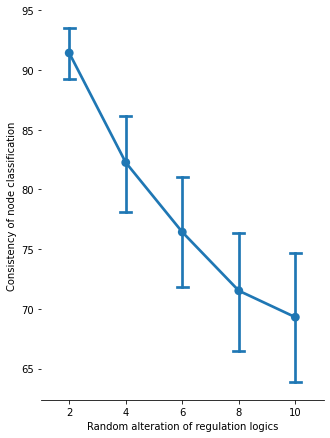

In [123]:
g = sns.catplot(
    data=summary_pd, x="damage", y="value",
    capsize=.2, errorbar="sd",
    kind="point", height=6, aspect=.75,
)
g.despine(left=True)
g.set_axis_labels('Random alteration of regulation logics', 'Consistency of node classification')
g.savefig('consistency.pdf', dpi=300)